In [1]:
from pathlib import Path
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
import logging

import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

pandas2ri.activate()
numpy2ri.activate()

output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)
figure_dir = output_dir / "figures"
figure_dir.mkdir(exist_ok=True)

/home/spark77/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_2772227/2053755192.py:20: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor="white")

-----
anndata     0.10.8
scanpy      1.10.3
-----
PIL                         9.4.0
anndata2ri                  1.3.2
anyio                       NA
argcomplete                 NA
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.16.0
backcall                    0.2.0
bottleneck                  1.3.7
brotli                      NA
certifi                     2025.08.03
cffi                        1.15.1
chardet                     5.1.0
charset_normalizer          2.0.4
cloudpickle                 2.0.0
colorama                    0.4.6
comm                        0.1.3
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.0
dask                        2023.7.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
dill                        0.3.6
exceptiongroup              1.1.2

## Data Preprocessing

In [3]:
data_root = Path("data_GSE179633_SLE")
data_dirs = {
    "DLE1113E": data_root / "DLE1113E", 
    "SLE1116E": data_root / "SLE1116E"
}

In [4]:
data_dirs

{'DLE1113E': PosixPath('data_GSE179633_SLE/DLE1113E'),
 'SLE1116E': PosixPath('data_GSE179633_SLE/SLE1116E')}

In [5]:
adatas = []
for batch, path in data_dirs.items():
    assert path.exists(), f"Missing path: {path}"
    ad_i = sc.read_10x_mtx(path, var_names="gene_symbols", cache=True)
    ad_i.var_names_make_unique()
    ad_i.obs["sample"] = batch
    ad_i.obs_names = [f"{x}-{batch}" for x in ad_i.obs_names]
    adatas.append(ad_i)

adata = ad.concat(adatas, join="outer", label="sample", keys=list(data_dirs.keys()))
adata.layers["counts"] = adata.X.copy()
adata

... reading from cache file cache/data_GSE179633_SLE-DLE1113E-matrix.h5ad
... reading from cache file cache/data_GSE179633_SLE-SLE1116E-matrix.h5ad


AnnData object with n_obs × n_vars = 9032 × 36601
    obs: 'sample'
    layers: 'counts'

In [6]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
adata.obs[["total_counts", "n_genes_by_counts", "pct_counts_mt"]].head()

,total_counts,n_genes_by_counts,pct_counts_mt
AAACCCAAGAAACCAT-1-DLE1113E,71374.0,7765,1.651862
AAACCCAAGGAACCAT-1-DLE1113E,3790.0,1612,1.187335
AAACCCAGTCTTCAAG-1-DLE1113E,1822.0,925,0.933041
AAACCCAGTTGCATCA-1-DLE1113E,3291.0,1326,0.546946
AAACCCATCACGAGGA-1-DLE1113E,558.0,134,67.025085


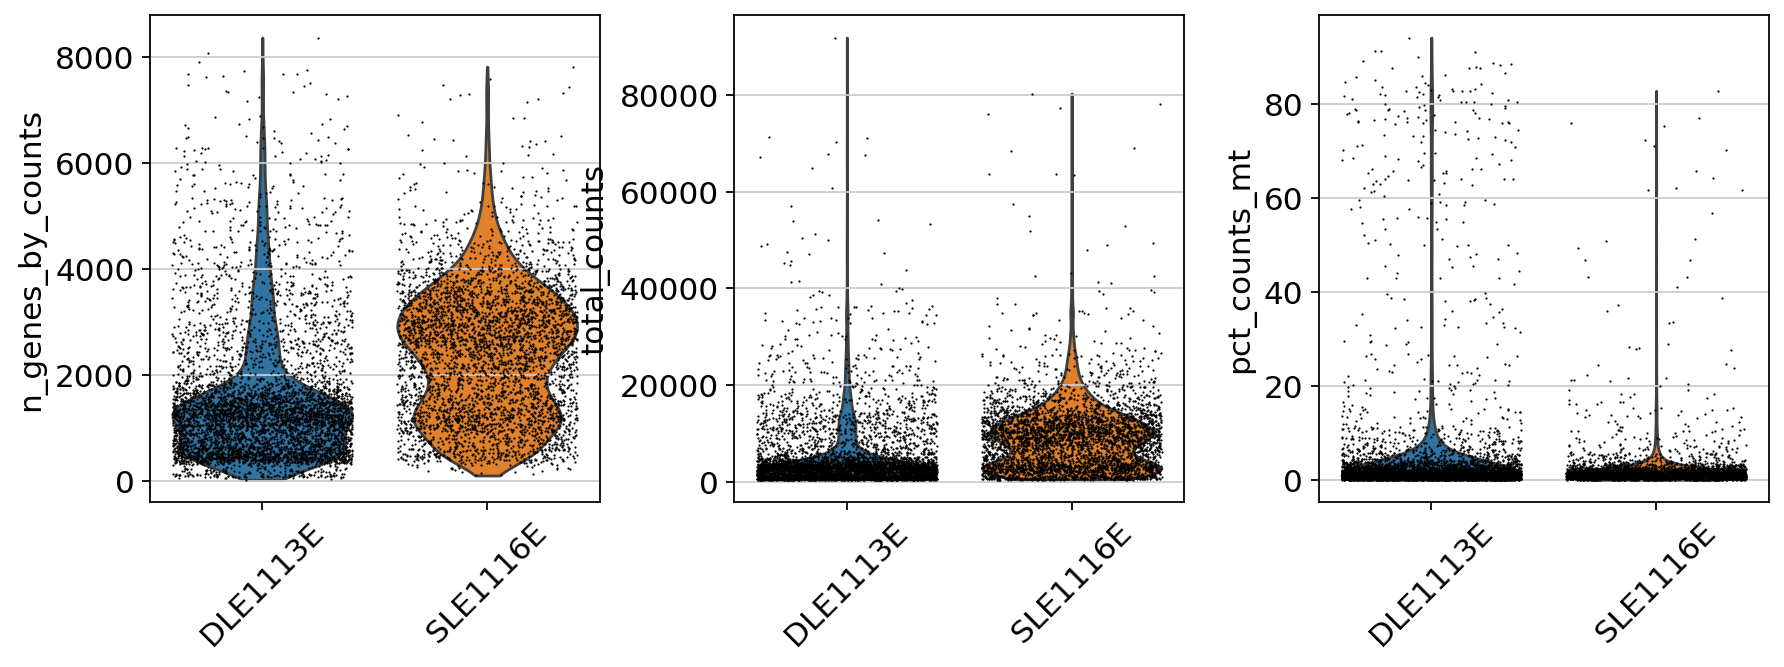

In [7]:
sc.pl.violin(
    adata, 
    keys=["n_genes_by_counts", "total_counts", "pct_counts_mt"], 
    groupby="sample", 
    rotation=45, 
    jitter=0.4, 
    multi_panel=True, 
    save="_qc_violin_per_sample.png"
)

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 143 cells that have less than 200 genes expressed
filtered out 13647 genes that are detected in less than 3 cells


In [9]:
min_genes = 200
max_genes = None
max_pct_mt = 10.0

qc_mask = np.ones(adata.n_obs, dtype=bool)
if min_genes is not None:
    qc_mask &= adata.obs["n_genes_by_counts"] >= min_genes
if max_genes is not None:
    qc_mask &= adata.obs["n_genes_by_counts"] <= max_genes
if max_pct_mt is not None:
    qc_mask &= adata.obs["pct_counts_mt"] <= max_pct_mt

adata_filt = adata[qc_mask].copy()
print(f"After QC: {adata_filt.n_obs} / {adata.n_obs}")

After QC: 8559 / 8889


## Doublet Removal

In [10]:
from rpy2.rinterface_lib import callbacks
import sys
callbacks.consolewrite_print = lambda x: sys.stdout.write(x)
callbacks.consolewrite_warnerror = lambda x: sys.stdout.write(x)

ro.r('''
library(SingleCellExperiment)
library(scDblFinder)
run_scdbl <- function(counts_mat, seed=777) {
    set.seed(seed)
    sce <- SingleCellExperiment(list(counts = counts_mat))
    sce <- scDblFinder(sce, verbose=TRUE)
    data.frame(
        scDblFinder_score = sce$scDblFinder.score, 
        scDblFinder_class = as.character(sce$scDblFinder.class), 
        stringsAsFactors = FALSE
    )
}
''')

adata_filt.obs["scDblFinder_score"] = np.nan
adata_filt.obs["scDblFinder_class"] = pd.Categorical([None]*adata_filt.n_obs, categories=["singlet", "doublet"])

for b in sorted(adata_filt.obs["sample"].unique()):
    ad_b = adata_filt[adata_filt.obs["sample"] == b]
    print(f"[scDblFinder] batch={b}, cells={ad_b.n_obs}")
    
    data_mat = ad_b.X.T
    if not isinstance(data_mat, np.ndarray):
        import scipy.sparse as sp
        if sp.issparse(data_mat):
            data_mat = data_mat.A
    
    with localconverter(ro.default_converter + numpy2ri.converter + pandas2ri.converter):
        ro.globalenv["counts_mat"] = data_mat
        df = ro.r("run_scdbl(counts_mat)")
        df = pd.DataFrame(df)
    
    adata_filt.obs.loc[ad_b.obs_names, "scDblFinder_score"] = pd.to_numeric(df["scDblFinder_score"], errors="coerce")
    adata_filt.obs.loc[ad_b.obs_names, "scDblFinder_class"] = pd.Categorical(df["scDblFinder_class"].astype(str), categories=["singlet", "doublet"])

필요한 패키지를 로딩중입니다: SummarizedExperiment
필요한 패키지를 로딩중입니다: MatrixGenerics
필요한 패키지를 로딩중입니다: matrixStats

다음의 패키지를 부착합니다: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds

In [11]:
adata_filt.obs["scDblFinder_class"].value_counts(dropna=False)

scDblFinder_class
singlet    7847
doublet     712
Name: count, dtype: int64

In [12]:
keep = adata_filt.obs["scDblFinder_class"] == "singlet"
adata_integrated = adata_filt[keep].copy()
print(f"After doublet removal: {adata_integrated.n_obs} / {adata_filt.n_obs}")

After doublet removal: 7847 / 8559


In [13]:
adata_integrated.layers["counts"] = adata_integrated.X.copy()

In [14]:
sc.pp.normalize_total(adata_integrated, target_sum=1e4)
sc.pp.log1p(adata_integrated)

normalizing counts per cell
    finished (0:00:00)


In [15]:
sc.pp.highly_variable_genes(
    adata_integrated,
    layer="counts",
    n_top_genes=2000,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    flavor="seurat_v3", 
    batch_key="sample"
)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [16]:
adata_integrated.layers["scaled"] = adata_integrated.X.toarray()
sc.pp.regress_out(adata_integrated, ["total_counts", "pct_counts_mt"], layer="scaled")
sc.pp.scale(adata_integrated, max_value=10, layer="scaled")

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:02:08)


## Principal Component Analysis (PCA)

In [17]:
sc.tl.pca(adata_integrated, n_comps=50, svd_solver="arpack", use_highly_variable=True)

computing PCA
    with n_comps=50


/home/spark77/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:00)


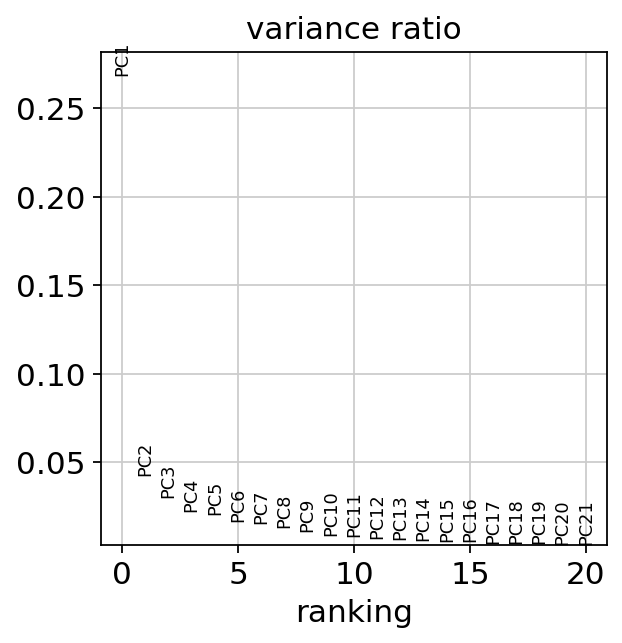

In [18]:
sc.pl.pca_variance_ratio(adata_integrated, n_pcs=20)

## Data integration using Harmony

In [19]:
import scanpy.external as scext
scext.pp.harmony_integrate(adata_integrated, key="sample", basis="X_pca")

2025-10-28 10:17:06,799 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ced70e74790>
Traceback (most recent call last):
  File "/home/spark77/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/spark77/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/spark77/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/spark77/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling

2025-10-28 10:17:08,470 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-28 10:17:08,511 - harmonypy - INFO - Iteration 1 of 10
2025-10-28 10:17:09,678 - harmonypy - INFO - Iteration 2 of 10
2025-10-28 10:17:10,830 - harmonypy - INFO - Iteration 3 of 10
2025-10-28 10:17:11,992 - harmonypy - INFO - Converged after 3 iterations


In [20]:
adata_integrated.obsm["X_pca_harmony"] = adata_integrated.obsm["X_pca_harmony"].astype("float32")

## Computing the neighborhood graph

In [21]:
sc.pp.neighbors(adata_integrated, use_rep="X_pca_harmony", n_neighbors=15, n_pcs=10, metric='euclidean')

computing neighbors


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ceb3edf5f70>
Traceback (most recent call last):
  File "/home/spark77/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/spark77/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/spark77/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/spark77/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


## UMAP

In [22]:
sc.tl.umap(adata_integrated, min_dist=0.3)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


## Graph-based Clustering

In [23]:
sc.tl.leiden(
    adata_integrated,
    resolution=0.5,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [24]:
adata_integrated.obs["leiden"] = adata_integrated.obs["leiden"].copy()
adata_integrated.uns["leiden"] = adata_integrated.uns["leiden"].copy()
adata_integrated.obsm["X_umap"] = adata_integrated.obsm["X_umap"].copy()

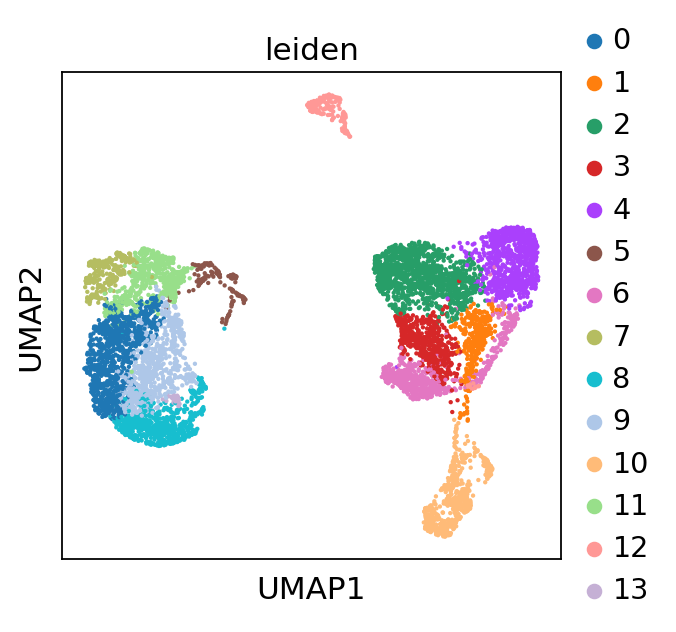

In [25]:
sc.pl.umap(adata_integrated, color=["leiden"])

## Finding marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


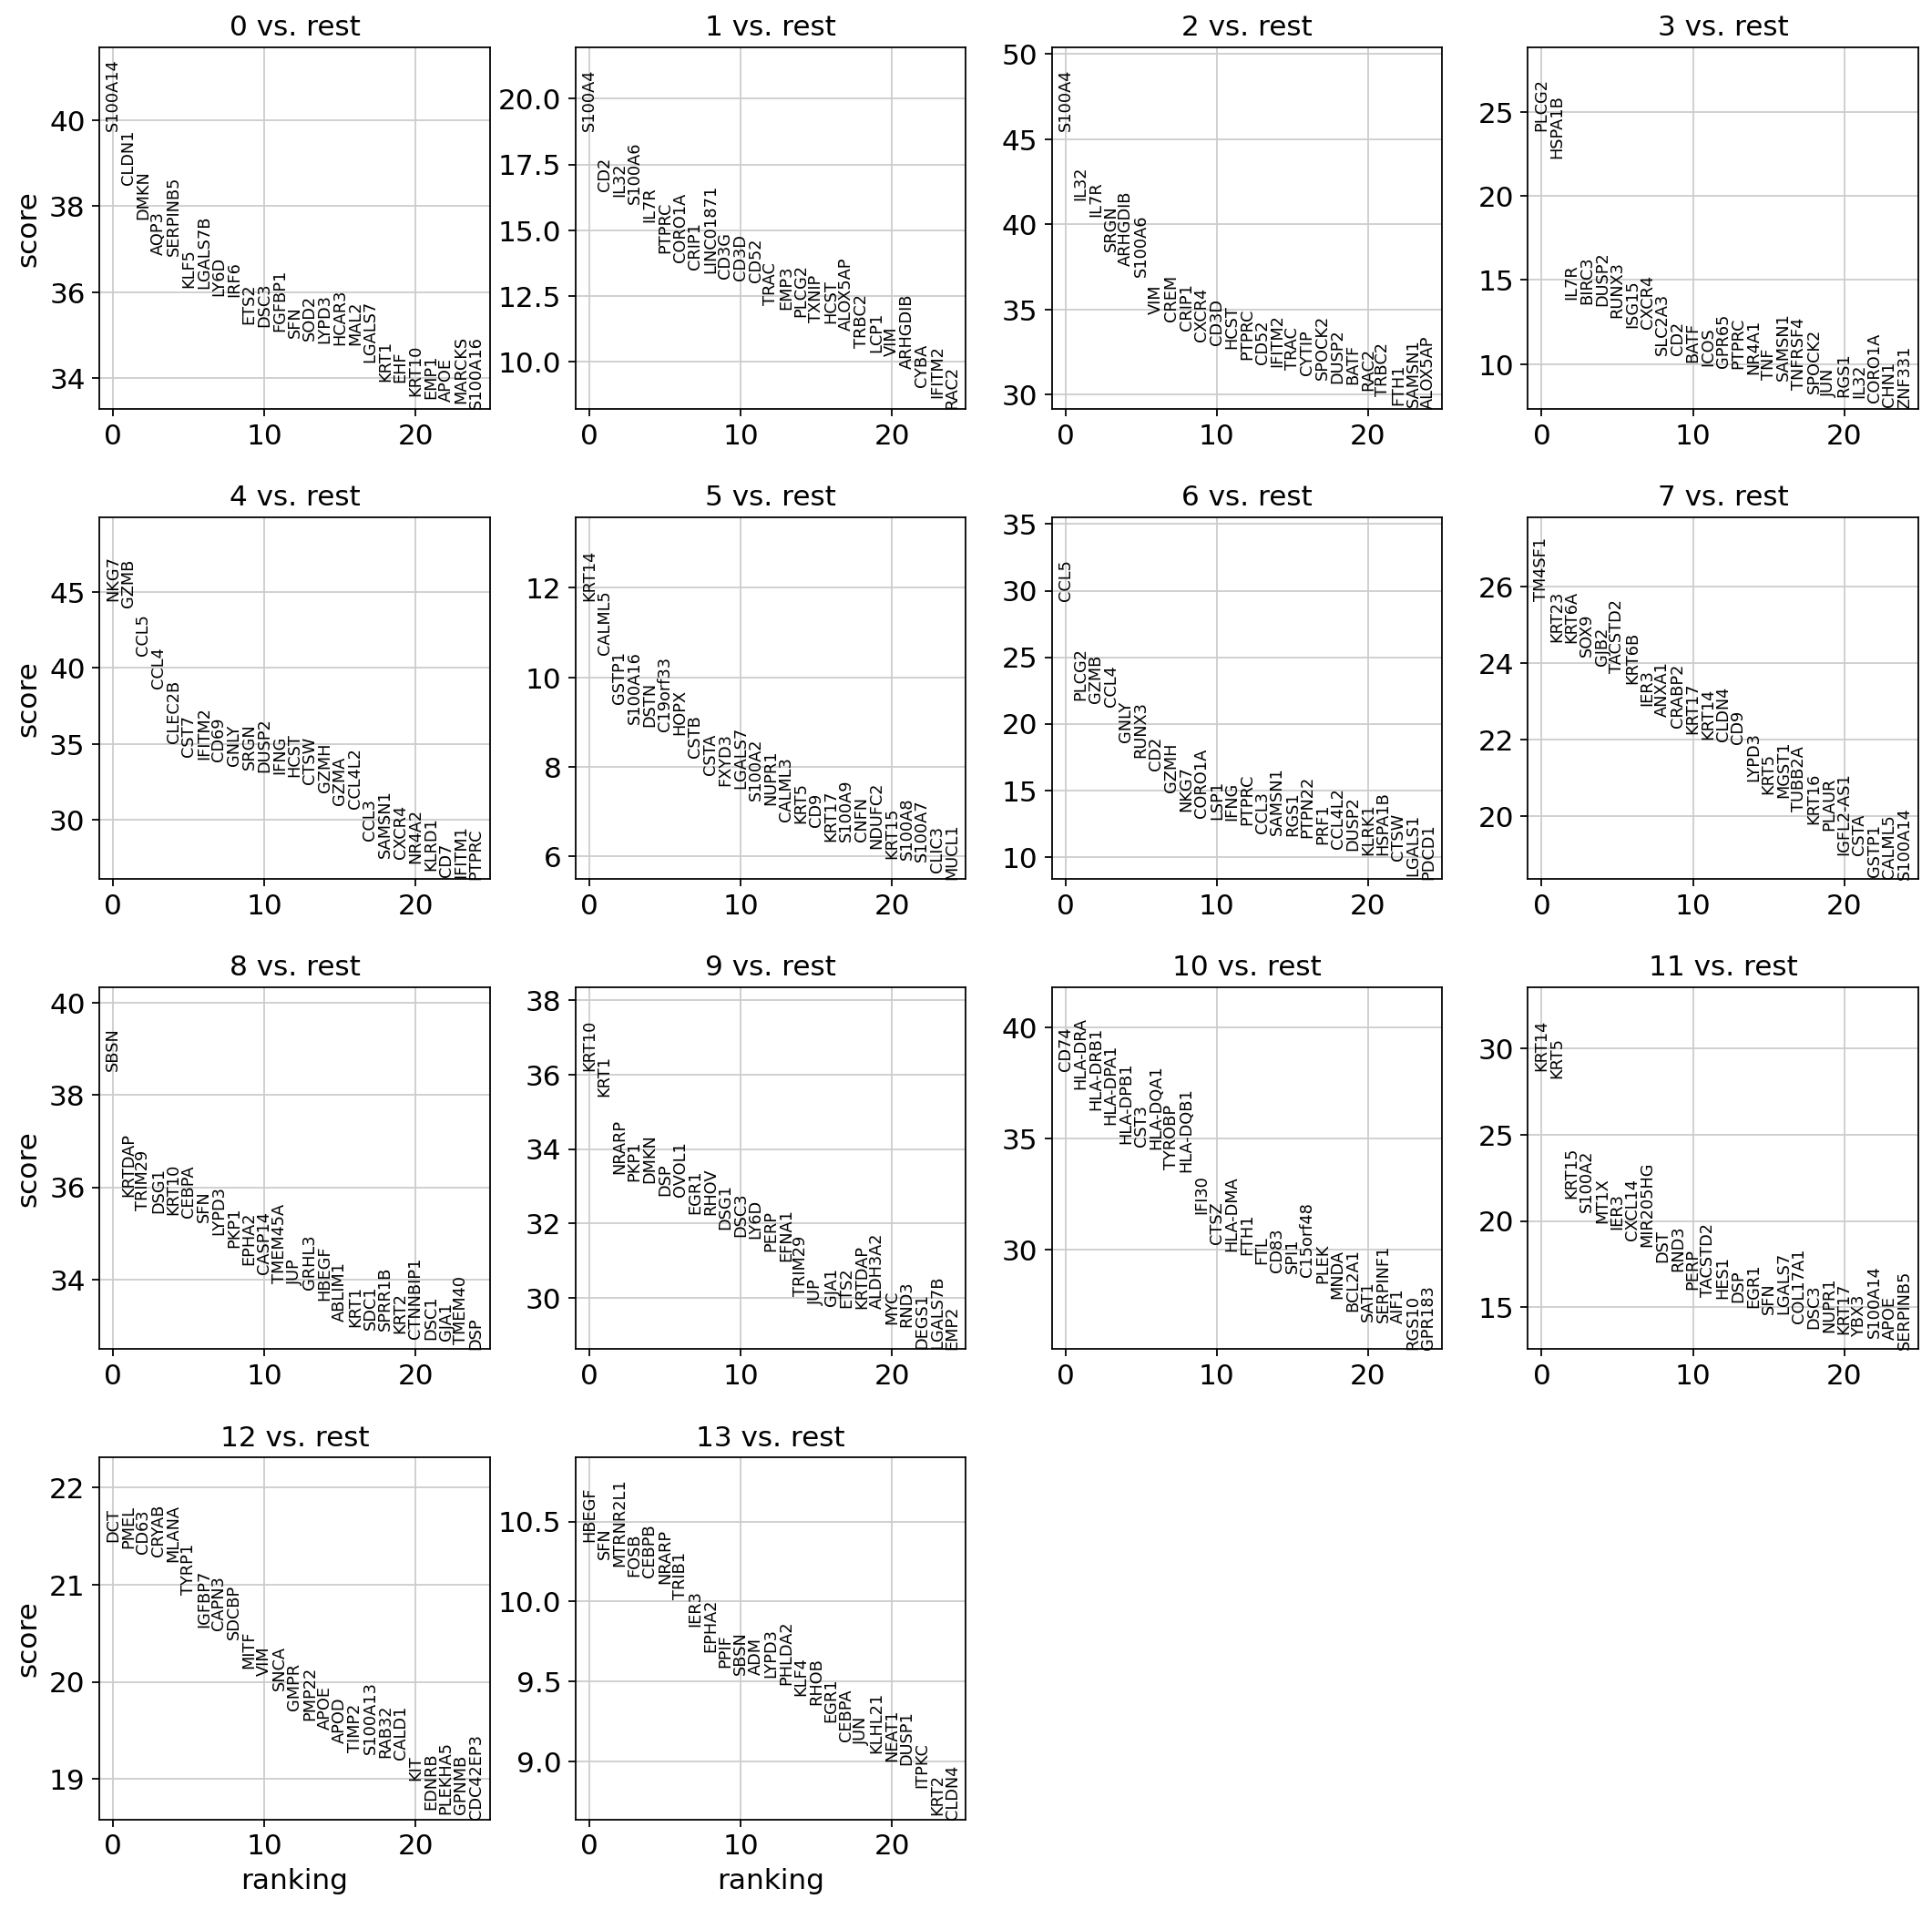

In [26]:
sc.tl.rank_genes_groups(adata_integrated, "leiden", mask_var="highly_variable", method="wilcoxon")
sc.pl.rank_genes_groups(adata_integrated, n_genes=25, sharey=False)

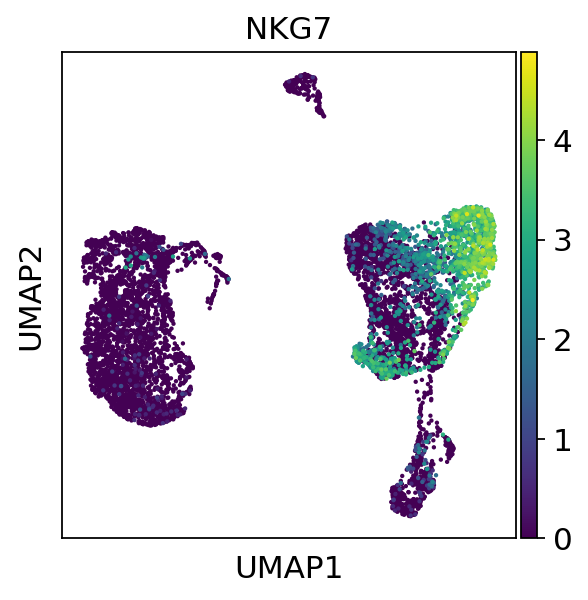

In [27]:
sc.pl.umap(adata_integrated, color=["NKG7"])

## Cell type annotation

In [ ]:
# (Write your code)

## Differentially expressed genes

In [ ]:
# (Write your code)